# AB 테스트 분석

이 노트북은 ab_testing.csv 데이터를 사용하여 A/B 테스트 결과를 분석합니다.

## 데이터 구조
- User ID: 사용자 고유 ID
- Group: A 또는 B 그룹 (테스트 그룹)
- Page Views: 페이지 조회수
- Time Spent: 사이트에서 보낸 시간 (초)
- Conversion: 전환 여부 (Yes/No)
- Device: 사용 기기 (Mobile/Desktop)
- Location: 사용자 위치

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. 데이터 로딩 및 기본 탐색

In [2]:
df = pd.read_csv('ab_testing.csv')

print("데이터 기본 정보:")
print(f"총 샘플 수: {len(df)}")
print(f"컬럼 수: {len(df.columns)}")
print("\n데이터 첫 5행:")
df.head()

데이터 기본 정보:
총 샘플 수: 5000
컬럼 수: 7

데이터 첫 5행:


,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [3]:
print("데이터 타입:")
print(df.dtypes)
print("\n결측값 확인:")
print(df.isnull().sum())
print("\n기본 통계:")
df.describe()

데이터 타입:
User ID        int64
Group         object
Page Views     int64
Time Spent     int64
Conversion    object
Device        object
Location      object
dtype: object

결측값 확인:
User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

기본 통계:


,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


## 2. 그룹별 기본 분석

In [4]:
print("그룹별 샘플 수:")
group_counts = df['Group'].value_counts()
print(group_counts)
print(f"\n그룹 비율:")
print(df['Group'].value_counts(normalize=True))

그룹별 샘플 수:
Group
A    2519
B    2481
Name: count, dtype: int64

그룹 비율:
Group
A    0.5038
B    0.4962
Name: proportion, dtype: float64


In [5]:
df['Conversion_Binary'] = df['Conversion'].map({'Yes': 1, 'No': 0})

print("그룹별 주요 지표:")
group_summary = df.groupby('Group').agg({
    'Page Views': ['mean', 'std', 'median'],
    'Time Spent': ['mean', 'std', 'median'],
    'Conversion_Binary': ['mean', 'sum', 'count']
}).round(2)

group_summary

그룹별 주요 지표:


Page Views              Time Spent                Conversion_Binary  \
            mean   std median       mean     std median              mean   
Group                                                                       
A           7.58  4.08    8.0     241.73  117.34  241.0              0.05   
B           7.49  3.96    8.0     243.30  119.19  244.0              0.14   

                  
       sum count  
Group             
A      136  2519  
B      349  2481

## 3. 시각화

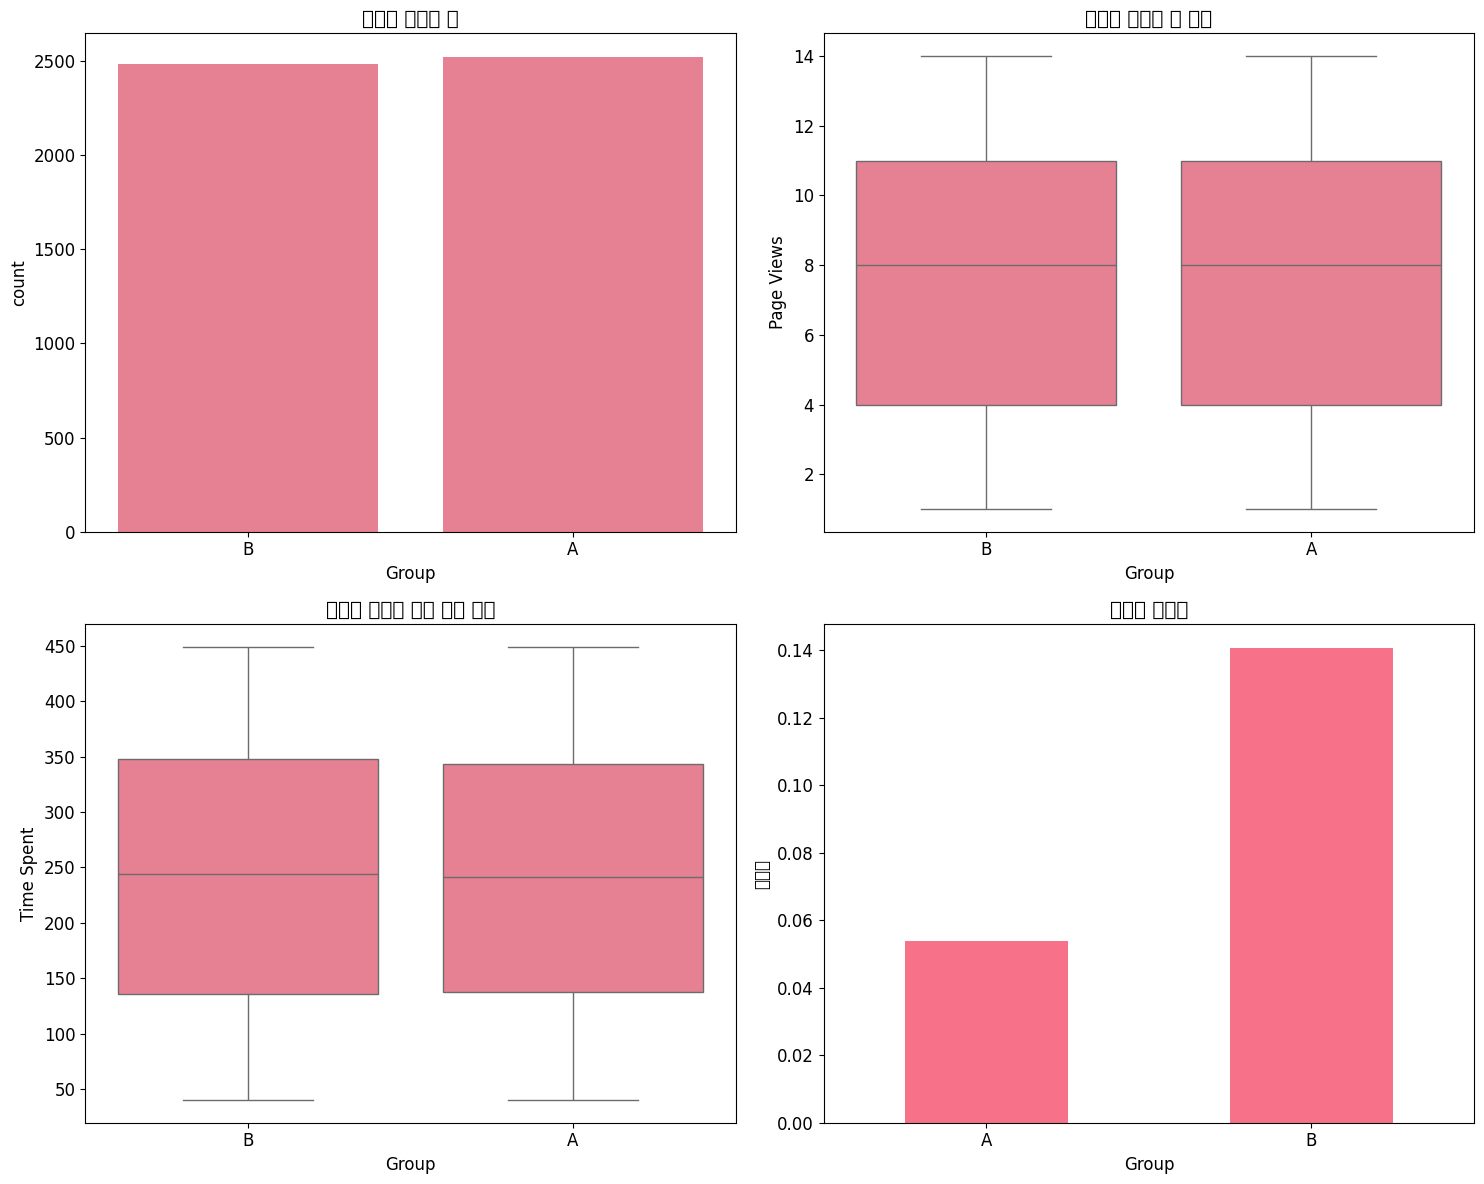

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.countplot(data=df, x='Group', ax=axes[0,0])
axes[0,0].set_title('그룹별 사용자 수')

sns.boxplot(data=df, x='Group', y='Page Views', ax=axes[0,1])
axes[0,1].set_title('그룹별 페이지 뷰 분포')

sns.boxplot(data=df, x='Group', y='Time Spent', ax=axes[1,0])
axes[1,0].set_title('그룹별 사이트 이용 시간 분포')

conversion_by_group = df.groupby('Group')['Conversion_Binary'].mean()
conversion_by_group.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('그룹별 전환율')
axes[1,1].set_ylabel('전환율')
axes[1,1].set_xticklabels(['A', 'B'], rotation=0)

plt.tight_layout()
plt.show()

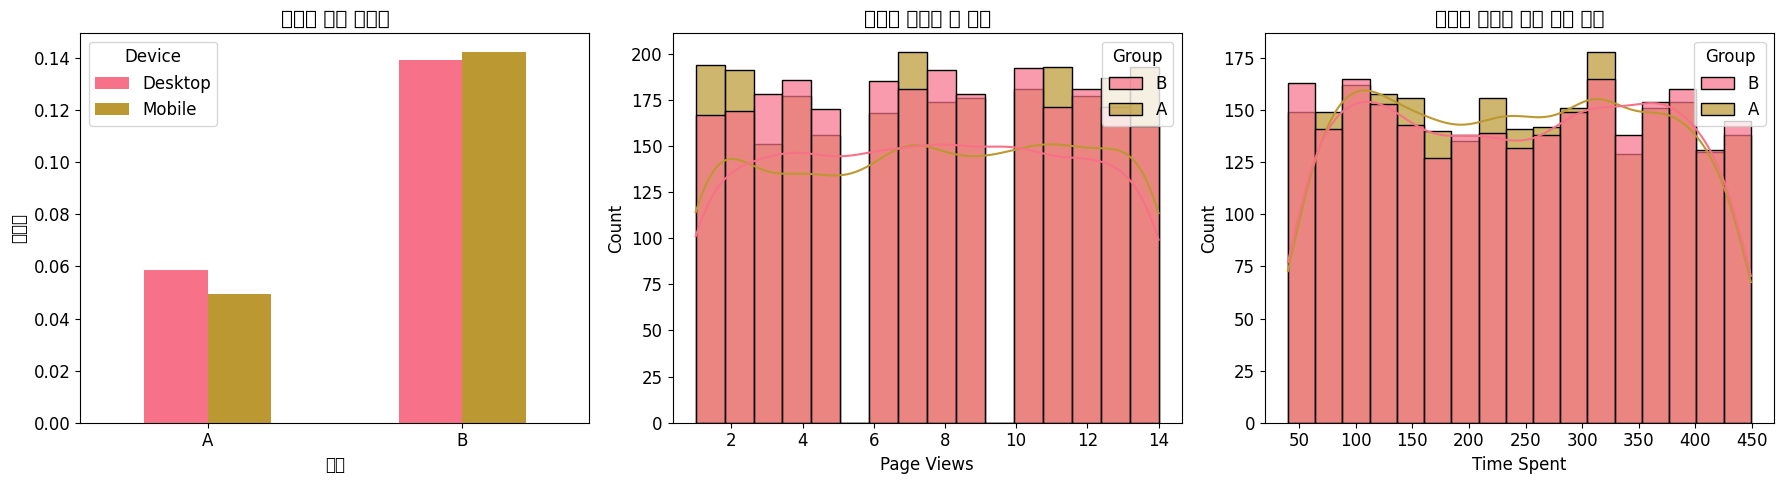

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

device_conversion = df.groupby(['Group', 'Device'])['Conversion_Binary'].mean().unstack()
device_conversion.plot(kind='bar', ax=axes[0])
axes[0].set_title('기기별 그룹 전환율')
axes[0].set_xlabel('그룹')
axes[0].set_ylabel('전환율')
axes[0].legend(title='Device')
axes[0].set_xticklabels(['A', 'B'], rotation=0)

sns.histplot(data=df, x='Page Views', hue='Group', kde=True, ax=axes[1], alpha=0.7)
axes[1].set_title('그룹별 페이지 뷰 분포')

sns.histplot(data=df, x='Time Spent', hue='Group', kde=True, ax=axes[2], alpha=0.7)
axes[2].set_title('그룹별 사이트 이용 시간 분포')

plt.tight_layout()
plt.show()

## 4. 통계적 유의성 검정

### 4.1 전환율 비교 (카이제곱 검정)

In [8]:
contingency_table = pd.crosstab(df['Group'], df['Conversion'])
print("전환율 교차표:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n카이제곱 검정 결과:")
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"자유도: {dof}")

if p_value < 0.05:
    print("결론: 통계적으로 유의한 차이가 있습니다. (p < 0.05)")
else:
    print("결론: 통계적으로 유의한 차이가 없습니다. (p >= 0.05)")

전환율 교차표:
Conversion    No  Yes
Group                
A           2383  136
B           2132  349

카이제곱 검정 결과:
카이제곱 통계량: 106.2281
p-value: 0.0000
자유도: 1
결론: 통계적으로 유의한 차이가 있습니다. (p < 0.05)


In [9]:
group_a = df[df['Group'] == 'A']
group_b = df[df['Group'] == 'B']

conv_rate_a = group_a['Conversion_Binary'].mean()
conv_rate_b = group_b['Conversion_Binary'].mean()

print(f"그룹 A 전환율: {conv_rate_a:.4f} ({conv_rate_a*100:.2f}%)")
print(f"그룹 B 전환율: {conv_rate_b:.4f} ({conv_rate_b*100:.2f}%)")
print(f"차이: {abs(conv_rate_b - conv_rate_a):.4f} ({abs(conv_rate_b - conv_rate_a)*100:.2f}%p)")

if conv_rate_b > conv_rate_a:
    improvement = ((conv_rate_b - conv_rate_a) / conv_rate_a) * 100
    print(f"그룹 B가 그룹 A보다 {improvement:.2f}% 높은 전환율을 보입니다.")
else:
    improvement = ((conv_rate_a - conv_rate_b) / conv_rate_b) * 100
    print(f"그룹 A가 그룹 B보다 {improvement:.2f}% 높은 전환율을 보입니다.")

그룹 A 전환율: 0.0540 (5.40%)
그룹 B 전환율: 0.1407 (14.07%)
차이: 0.0867 (8.67%p)
그룹 B가 그룹 A보다 160.55% 높은 전환율을 보입니다.


### 4.2 페이지 뷰 비교 (t-검정)

In [10]:
page_views_a = group_a['Page Views']
page_views_b = group_b['Page Views']

t_stat, p_value = ttest_ind(page_views_a, page_views_b)

print(f"페이지 뷰 t-검정 결과:")
print(f"그룹 A 평균 페이지 뷰: {page_views_a.mean():.2f} ± {page_views_a.std():.2f}")
print(f"그룹 B 평균 페이지 뷰: {page_views_b.mean():.2f} ± {page_views_b.std():.2f}")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("결론: 페이지 뷰에 통계적으로 유의한 차이가 있습니다.")
else:
    print("결론: 페이지 뷰에 통계적으로 유의한 차이가 없습니다.")

페이지 뷰 t-검정 결과:
그룹 A 평균 페이지 뷰: 7.58 ± 4.08
그룹 B 평균 페이지 뷰: 7.49 ± 3.96
t-통계량: 0.7790
p-value: 0.4360
결론: 페이지 뷰에 통계적으로 유의한 차이가 없습니다.


### 4.3 사이트 이용 시간 비교 (t-검정)

In [11]:
time_spent_a = group_a['Time Spent']
time_spent_b = group_b['Time Spent']

t_stat, p_value = ttest_ind(time_spent_a, time_spent_b)

print(f"사이트 이용 시간 t-검정 결과:")
print(f"그룹 A 평균 이용 시간: {time_spent_a.mean():.2f} ± {time_spent_a.std():.2f} 초")
print(f"그룹 B 평균 이용 시간: {time_spent_b.mean():.2f} ± {time_spent_b.std():.2f} 초")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("결론: 사이트 이용 시간에 통계적으로 유의한 차이가 있습니다.")
else:
    print("결론: 사이트 이용 시간에 통계적으로 유의한 차이가 없습니다.")

사이트 이용 시간 t-검정 결과:
그룹 A 평균 이용 시간: 241.73 ± 117.34 초
그룹 B 평균 이용 시간: 243.30 ± 119.19 초
t-통계량: -0.4695
p-value: 0.6387
결론: 사이트 이용 시간에 통계적으로 유의한 차이가 없습니다.


## 5. 세그먼트별 분석

### 5.1 기기별 분석

In [12]:
device_analysis = df.groupby(['Device', 'Group']).agg({
    'Conversion_Binary': ['mean', 'count'],
    'Page Views': 'mean',
    'Time Spent': 'mean'
}).round(3)

print("기기별 그룹 분석:")
print(device_analysis)

기기별 그룹 분석:
              Conversion_Binary       Page Views Time Spent
                           mean count       mean       mean
Device  Group                                              
Desktop A                 0.059  1244      7.519    243.131
        B                 0.139  1294      7.541    243.238
Mobile  A                 0.049  1275      7.642    240.369
        B                 0.142  1187      7.441    243.376


In [13]:
for device in df['Device'].unique():
    device_data = df[df['Device'] == device]
    device_crosstab = pd.crosstab(device_data['Group'], device_data['Conversion'])
    
    if device_crosstab.shape[0] > 1 and device_crosstab.shape[1] > 1:
        chi2, p_value, dof, expected = chi2_contingency(device_crosstab)
        print(f"\n{device} 기기 전환율 카이제곱 검정:")
        print(f"p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"{device} 기기에서 그룹 간 유의한 차이 발견")
        else:
            print(f"{device} 기기에서 그룹 간 유의한 차이 없음")


Mobile 기기 전환율 카이제곱 검정:
p-value: 0.0000
Mobile 기기에서 그룹 간 유의한 차이 발견

Desktop 기기 전환율 카이제곱 검정:
p-value: 0.0000
Desktop 기기에서 그룹 간 유의한 차이 발견


### 5.2 지역별 분석

In [14]:
location_analysis = df.groupby(['Location', 'Group'])['Conversion_Binary'].agg(['mean', 'count']).round(3)
print("지역별 그룹 전환율:")
print(location_analysis)

지역별 그룹 전환율:
                         mean  count
Location         Group              
England          A      0.069    606
                 B      0.147    640
Northern Ireland A      0.050    614
                 B      0.115    628
Scotland         A      0.049    670
                 B      0.151    611
Wales            A      0.048    629
                 B      0.151    602


<Figure size 1200x800 with 0 Axes>

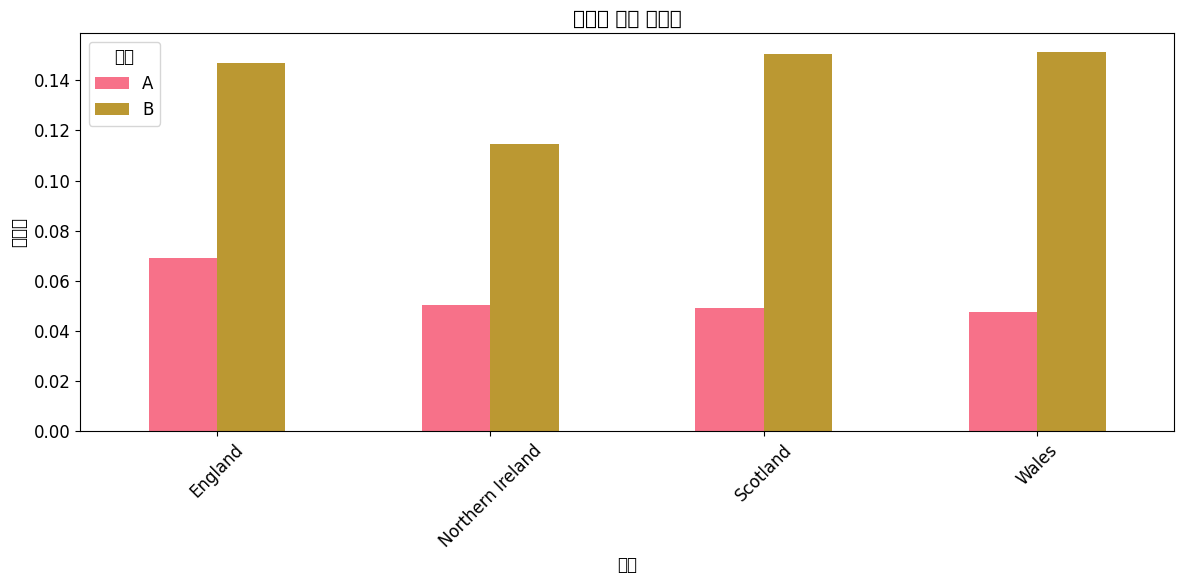

In [15]:
plt.figure(figsize=(12, 8))
location_pivot = df.pivot_table(values='Conversion_Binary', 
                               index='Location', 
                               columns='Group', 
                               aggfunc='mean')
location_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('지역별 그룹 전환율')
plt.ylabel('전환율')
plt.xlabel('지역')
plt.xticks(rotation=45)
plt.legend(title='그룹')
plt.tight_layout()
plt.show()

## 6. 효과 크기 및 신뢰구간

In [16]:
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n-1)
    return mean - h, mean + h

conv_a_ci = calculate_confidence_interval(group_a['Conversion_Binary'])
conv_b_ci = calculate_confidence_interval(group_b['Conversion_Binary'])

print(f"그룹 A 전환율 95% 신뢰구간: [{conv_a_ci[0]:.4f}, {conv_a_ci[1]:.4f}]")
print(f"그룹 B 전환율 95% 신뢰구간: [{conv_b_ci[0]:.4f}, {conv_b_ci[1]:.4f}]")

effect_size = abs(conv_rate_b - conv_rate_a) / np.sqrt((conv_rate_a * (1 - conv_rate_a) + conv_rate_b * (1 - conv_rate_b)) / 2)
print(f"\n효과 크기 (Cohen's d): {effect_size:.4f}")

if effect_size < 0.2:
    print("효과 크기: 작음")
elif effect_size < 0.5:
    print("효과 크기: 중간")
else:
    print("효과 크기: 큼")

그룹 A 전환율 95% 신뢰구간: [0.0452, 0.0628]
그룹 B 전환율 95% 신뢰구간: [0.1270, 0.1544]

효과 크기 (Cohen's d): 0.2956
효과 크기: 중간


## 7. 최종 결론 및 권장사항

In [17]:
print("=== AB 테스트 결과 요약 ===")
print(f"\n1. 샘플 크기:")
print(f"   - 그룹 A: {len(group_a)} 명")
print(f"   - 그룹 B: {len(group_b)} 명")

print(f"\n2. 주요 지표 비교:")
print(f"   - 그룹 A 전환율: {conv_rate_a:.4f} ({conv_rate_a*100:.2f}%)")
print(f"   - 그룹 B 전환율: {conv_rate_b:.4f} ({conv_rate_b*100:.2f}%)")
print(f"   - 전환율 차이: {abs(conv_rate_b - conv_rate_a):.4f} ({abs(conv_rate_b - conv_rate_a)*100:.2f}%p)")

print(f"\n3. 통계적 유의성:")
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Group'], df['Conversion']))
if p_value < 0.05:
    print(f"   - 전환율에 통계적으로 유의한 차이 있음 (p = {p_value:.4f})")
    if conv_rate_b > conv_rate_a:
        print(f"   - 그룹 B가 그룹 A보다 우수")
        print(f"   - 권장사항: 그룹 B 버전을 전체 사용자에게 배포")
    else:
        print(f"   - 그룹 A가 그룹 B보다 우수")
        print(f"   - 권장사항: 현재 버전(그룹 A) 유지")
else:
    print(f"   - 전환율에 통계적으로 유의한 차이 없음 (p = {p_value:.4f})")
    print(f"   - 권장사항: 추가 데이터 수집 또는 다른 지표 검토 필요")

print(f"\n4. 추가 고려사항:")
print(f"   - 기기별, 지역별 세그먼트 분석 결과 검토 필요")
print(f"   - 비즈니스 임팩트 및 구현 비용 고려")
print(f"   - 장기적인 효과 모니터링 권장")

=== AB 테스트 결과 요약 ===

1. 샘플 크기:
   - 그룹 A: 2519 명
   - 그룹 B: 2481 명

2. 주요 지표 비교:
   - 그룹 A 전환율: 0.0540 (5.40%)
   - 그룹 B 전환율: 0.1407 (14.07%)
   - 전환율 차이: 0.0867 (8.67%p)

3. 통계적 유의성:
   - 전환율에 통계적으로 유의한 차이 있음 (p = 0.0000)
   - 그룹 B가 그룹 A보다 우수
   - 권장사항: 그룹 B 버전을 전체 사용자에게 배포

4. 추가 고려사항:
   - 기기별, 지역별 세그먼트 분석 결과 검토 필요
   - 비즈니스 임팩트 및 구현 비용 고려
   - 장기적인 효과 모니터링 권장
